In [124]:
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import requests

In [125]:
def download_file(url):
    file_path = url.split('/')[-1]
    resp = requests.get(url)
    with open(file_path, 'wb') as f:
        f.write(resp.content)
    return file_path

# 1. Redes de colaboração

- Artigos na área de astrofísica
- Publicados entre 1993 e 2003

[Link para o dataset](https://snap.stanford.edu/data/ca-AstroPh.html)

Referência:
- J. Leskovec, J. Kleinberg and C. Faloutsos. Graph Evolution: Densification and Shrinking Diameters. ACM Transactions on Knowledge Discovery from Data (ACM TKDD), 1(1), 2007.

In [126]:
url = 'https://snap.stanford.edu/data/ca-AstroPh.txt.gz'
file_path = download_file(url)
file_path

'ca-AstroPh.txt.gz'

In [127]:
G = nx.read_edgelist(file_path)
print(G)

Graph with 18772 nodes and 198110 edges


## Densidade da rede

In [128]:
nx.density(G)

0.0011244455715955115

## Conectividade

In [129]:
nx.is_connected(G)

False

Quantas **componentes conexas** existem na rede?

In [130]:
nx.number_connected_components(G)

290

In [131]:
components = nx.connected_components(G)
len(nx.connected_components(G))

TypeError: object of type 'generator' has no len()

Convertendo para `list` primeiro:

In [132]:
components = nx.connected_components(G)
len(list(components))

290

In [133]:
components = nx.connected_components(G)
sizes = []
for comp in components:
    sizes.append(len(comp))

Usando *list comprehension*:

In [134]:
components = nx.connected_components(G)
sizes = [len(comp) for comp in components]

In [136]:
sizes = pd.Series(sizes)
sizes.describe()

count      290.000000
mean        64.731034
std       1051.125146
min          1.000000
25%          2.000000
50%          3.000000
75%          3.000000
max      17903.000000
dtype: float64

Vamos analisar apenas a **maior componente**. Esse é um processo bastante comum.

In [137]:
components = nx.connected_components(G)
nodes = max(components, key=len)
nodes

{'82019',
 '90053',
 '82499',
 '130929',
 '91617',
 '115744',
 '87130',
 '74936',
 '5157',
 '62486',
 '31345',
 '60642',
 '28893',
 '70228',
 '130330',
 '16881',
 '89915',
 '61597',
 '46915',
 '57013',
 '120188',
 '93521',
 '115987',
 '88167',
 '103498',
 '122700',
 '16783',
 '55045',
 '117444',
 '11479',
 '32269',
 '27142',
 '53502',
 '62564',
 '112183',
 '93330',
 '58764',
 '66469',
 '47609',
 '11725',
 '88361',
 '132121',
 '22437',
 '105467',
 '52979',
 '76467',
 '84128',
 '68239',
 '25178',
 '133029',
 '130022',
 '46457',
 '12645',
 '69601',
 '52359',
 '59433',
 '39258',
 '16957',
 '105705',
 '42077',
 '17863',
 '26463',
 '9069',
 '76026',
 '118320',
 '72049',
 '110644',
 '72857',
 '125855',
 '121081',
 '72048',
 '62078',
 '123287',
 '92622',
 '89169',
 '92915',
 '101744',
 '90437',
 '61430',
 '74941',
 '25304',
 '9292',
 '66708',
 '84919',
 '132712',
 '127293',
 '108653',
 '9814',
 '97005',
 '43314',
 '119195',
 '119667',
 '52481',
 '101278',
 '52495',
 '97877',
 '9806',
 '84943',

In [138]:
H = G.subgraph(nodes)
print(H)

Graph with 17903 nodes and 197031 edges


Percentual de nós e arestas na **maior componente**:

In [139]:
H.number_of_nodes() / G.number_of_nodes()

0.9537076496910292

In [140]:
H.number_of_edges() / G.number_of_edges()

0.9945535308666902

## Distribuição dos graus

### Histograma

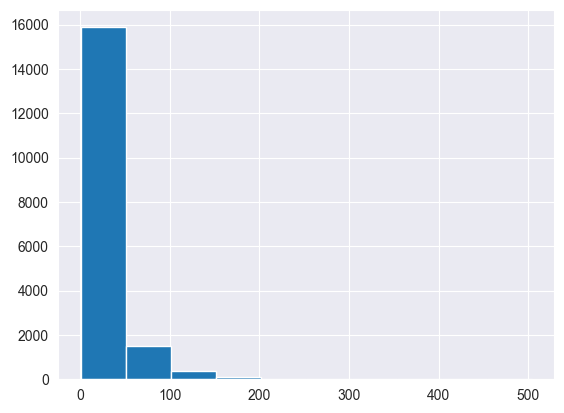

In [141]:
degree_list = [degree for node, degree in H.degree]
degree_list = pd.Series(degree_list)
degree_list.hist();

In [143]:
degree_list.describe()

count    17903.000000
mean        22.010948
std         31.016923
min          1.000000
25%          4.000000
50%         10.000000
75%         28.000000
max        504.000000
dtype: float64

### Gráfico de *ranqueamento*

Apesar de ter cauda longa, não parece seguir Lei de Potência

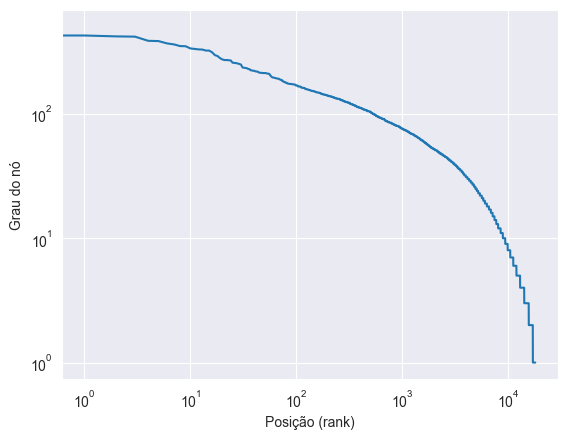

In [144]:
y = degree_list.sort_values(ascending=False)
x = range(len(y))
plt.plot(x, y)
plt.loglog()
plt.xlabel('Posição (rank)')
plt.ylabel('Grau do nó');

## Distâncias

Cálculo pode ser bastante demorado. Por isso vamos usar o módulo `approximation`:

In [145]:
nx.algorithms.approximation.diameter(H)

14

In [146]:
top_nodes = [node for node, degree in H.degree if degree > 350]
top_nodes

['1086',
 '21718',
 '35290',
 '38109',
 '53213',
 '92790',
 '89732',
 '93504',
 '62821']

In [147]:
distances = nx.shortest_path_length(H, '1086')
distances = pd.Series(distances)
distances.describe()

count    17903.000000
mean         2.875663
std          0.845950
min          0.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          9.000000
dtype: float64

In [148]:
distances = nx.shortest_path_length(H, '62821')
distances = pd.Series(distances)
distances.describe()

count    17903.000000
mean         2.858459
std          0.844698
min          0.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          9.000000
dtype: float64

## Clusterização

Mais uma vez, vamos usar uma **aproximação**:

In [149]:
nx.algorithms.approximation.average_clustering(H)

0.65

## Comparação com rede aleatória Erdös-Rényi

In [150]:
num_nodes = G.number_of_nodes()
density = nx.density(G)
random_graph = nx.erdos_renyi_graph(num_nodes, density, seed=42)
print(random_graph)

Graph with 18772 nodes and 197308 edges


### Clusterização

In [151]:
nx.algorithms.approximation.average_clustering(H)

0.626

In [152]:
nx.algorithms.approximation.average_clustering(random_graph)

0.0

### Número de componentes

In [153]:
nx.number_connected_components(G)

290

In [154]:
nx.number_connected_components(random_graph)

1

### Diâmetro

In [155]:
nx.algorithms.approximation.diameter(H)

14

In [156]:
nx.algorithms.approximation.diameter(random_graph)

5

### Distribuição dos graus

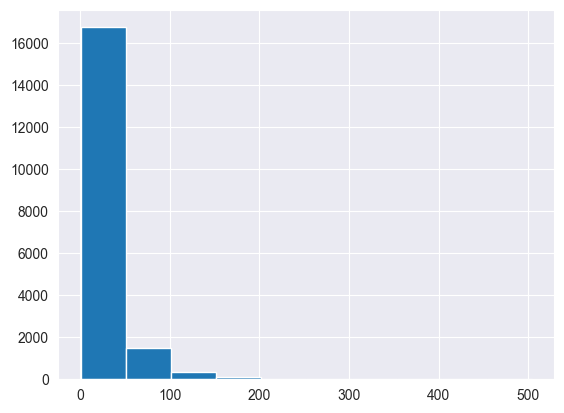

In [157]:
degree_list = [degree for node, degree in G.degree]
degree_list = pd.Series(degree_list)
degree_list.hist();

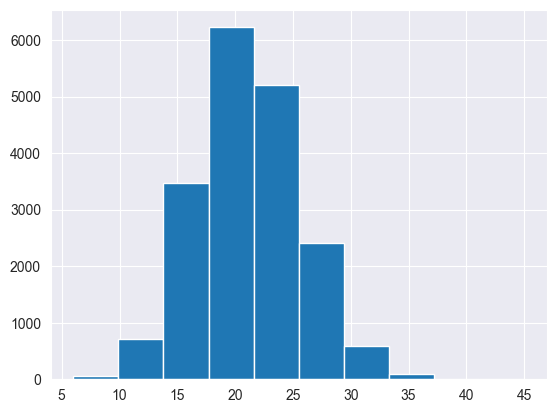

In [158]:
rng_degree_list = [degree for node, degree in random_graph.degree]
rng_degree_list = pd.Series(rng_degree_list)
rng_degree_list.hist();

# 2. Internet

"*Fotografia*" tirada em novembro de 2007

[Link para o dataset](https://snap.stanford.edu/data/as-Caida.html)

Referência:
- J. Leskovec, J. Kleinberg and C. Faloutsos. Graphs over Time: Densification Laws, Shrinking Diameters and Possible Explanations. ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 2005.

In [159]:
url = 'https://snap.stanford.edu/data/as-caida20071105.txt.gz'
file_path = download_file(url)
file_path

'as-caida20071105.txt.gz'

In [160]:
G = nx.read_weighted_edgelist(file_path)
print(G)

Graph with 26475 nodes and 53381 edges


## Densidade da rede

Dez vezes menor do que a rede de colaboração!

In [161]:
nx.density(G)

0.0001523214859084934

## Conectividade

Faz sentido que a rede seja conectada:

In [162]:
nx.is_connected(G)

True

Só existe uma **componente conexa** na rede:

In [163]:
nx.number_connected_components(G)

1

## Distribuição dos graus

### Histograma

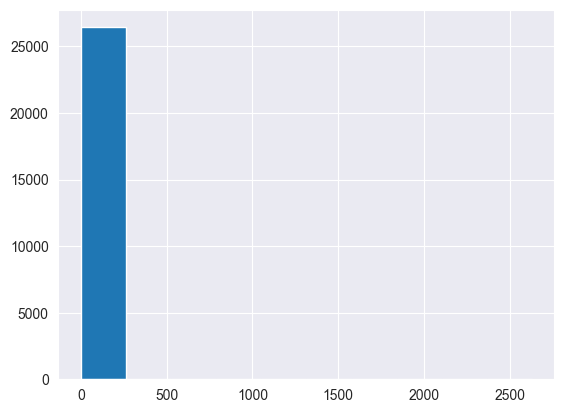

In [164]:
degree_list = [degree for node, degree in G.degree]
degree_list = pd.Series(degree_list)
degree_list.hist();

In [165]:
degree_list.describe()

count    26475.000000
mean         4.032559
std         33.374795
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max       2628.000000
dtype: float64

### Gráfico de *ranqueamento*

Provavelmente uma Lei de Potência!

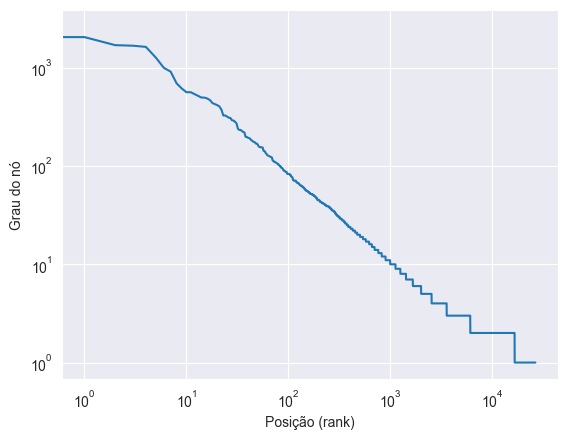

In [166]:
y = degree_list.sort_values(ascending=False)
x = range(len(y))
plt.plot(x, y)
plt.loglog()
plt.xlabel('Posição (rank)')
plt.ylabel('Grau do nó');

## Distâncias

Novamente usaremos a aproximação:

In [167]:
nx.algorithms.approximation.diameter(G)

17

In [168]:
top_nodes = [node for node, degree in G.degree if degree > 1500]
top_nodes

['174', '3356', '7018', '701', '1239']

In [169]:
distances = nx.shortest_path_length(G, '174')
distances = pd.Series(distances)
distances.describe()

count    26475.000000
mean         2.421870
std          0.728787
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         13.000000
dtype: float64

In [170]:
distances = nx.shortest_path_length(G, '3356')
distances = pd.Series(distances)
distances.describe()

count    26475.000000
mean         2.330538
std          0.675398
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         13.000000
dtype: float64

## Clusterização

Três vezes menor do que a da *Rede de colaboração*:

In [171]:
nx.algorithms.approximation.average_clustering(G)

0.208

## Comparação com rede aleatória Erdös-Rényi

In [172]:
num_nodes = G.number_of_nodes()
density = nx.density(G)
random_graph = nx.erdos_renyi_graph(num_nodes, density, seed=42)
print(random_graph)

Graph with 26475 nodes and 53285 edges


### Clusterização

In [173]:
nx.algorithms.approximation.average_clustering(G)

0.209

In [174]:
nx.algorithms.approximation.average_clustering(random_graph)

0.0

### Número de componentes

In [175]:
nx.number_connected_components(G)

1

In [176]:
nx.number_connected_components(random_graph)

474

### Diâmetro

In [177]:
nx.algorithms.approximation.diameter(G)

17

In [179]:
nx.algorithms.approximation.diameter(random_graph)

NetworkXError: Graph not connected.

Maior componente conexa do grafo aleatório:

In [180]:
components = nx.connected_components(random_graph)
nodes = max(components, key=len)
random_graph_comp = random_graph.subgraph(nodes)
print(random_graph_comp)

Graph with 25980 nodes and 53263 edges


In [181]:
nx.algorithms.approximation.diameter(random_graph_comp)

15

### Distribuição dos graus

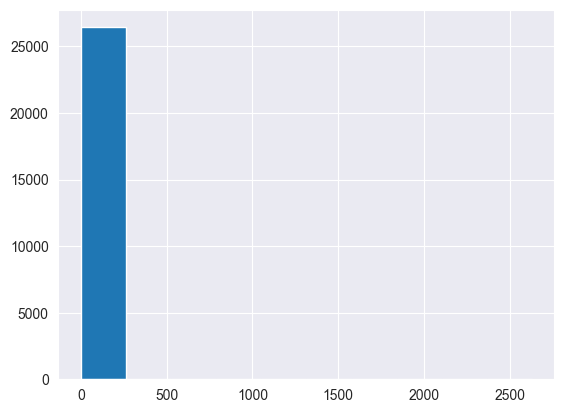

In [182]:
degree_list = [degree for node, degree in G.degree]
degree_list = pd.Series(degree_list)
degree_list.hist();

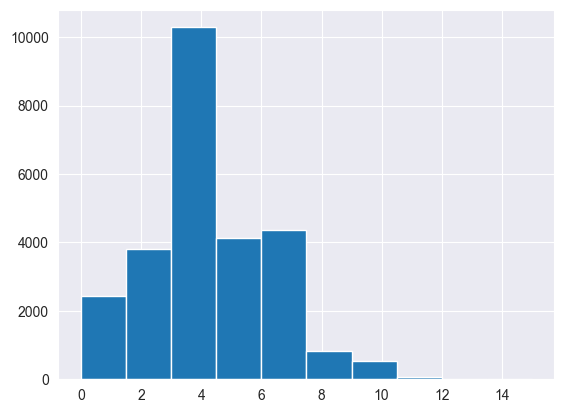

In [183]:
rng_degree_list = [degree for node, degree in random_graph.degree]
rng_degree_list = pd.Series(rng_degree_list)
rng_degree_list.hist();

# 3. Estradas

- Rede rodoviária do estado da Pensilvânia, EUA.
- Rede **direcionada**.

[Link para o dataset](https://snap.stanford.edu/data/roadNet-PA.html)

Referência:
- J. Leskovec, K. Lang, A. Dasgupta, M. Mahoney. Community Structure in Large Networks: Natural Cluster Sizes and the Absence of Large Well-Defined Clusters. Internet Mathematics 6(1) 29--123, 2009.

In [184]:
url = 'https://snap.stanford.edu/data/roadNet-PA.txt.gz'
file_path = download_file(url)
file_path

'roadNet-PA.txt.gz'

Essa rede pode demorar para carregar!

In [185]:
G = nx.read_edgelist(file_path, create_using=nx.DiGraph)
print(G)

DiGraph with 1088092 nodes and 3083796 edges


## Densidade da rede

Muito menor do que as outras! Por quê?

In [186]:
nx.density(G)

2.6046825795723353e-06

## Conectividade

Fortemente conexo -> caminho de **ida e volta**

In [187]:
nx.is_strongly_connected(G)

False

Quantas **componentes conexas fortes** existem na rede?

In [188]:
nx.number_strongly_connected_components(G)

206

Separando a **maior componente conexa forte**:

In [189]:
components = nx.strongly_connected_components(G)
nodes = max(components, key=len)
H = G.subgraph(nodes)
print(H)

DiGraph with 1087562 nodes and 3083028 edges


Percentual de nós e arestas na **maior componente**:

In [190]:
H.number_of_nodes() / G.number_of_nodes()

0.9995129088349147

In [191]:
H.number_of_edges() / G.number_of_edges()

0.9997509562889374

## Distribuição dos graus

### Histograma

Grau de entrada:

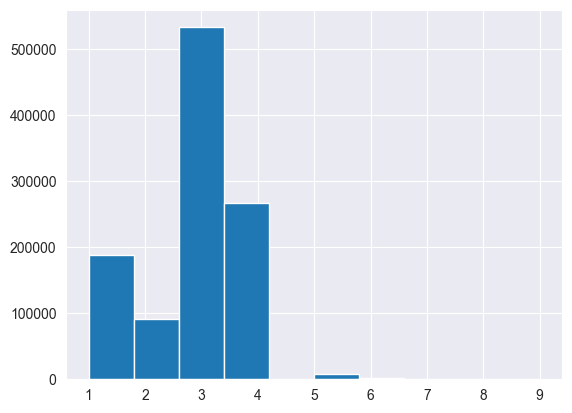

In [192]:
in_degree_list = [degree for node, degree in G.in_degree]
in_degree_list = pd.Series(in_degree_list)
in_degree_list.hist();

In [193]:
in_degree_list.describe()

count    1.088092e+06
mean     2.834132e+00
std      1.016930e+00
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      9.000000e+00
dtype: float64

Grau de saída:

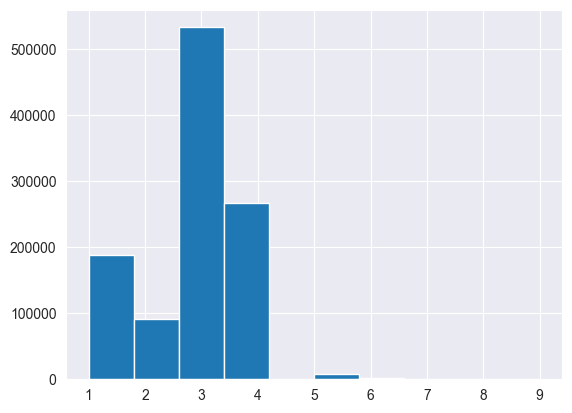

In [194]:
out_degree_list = [degree for node, degree in G.out_degree]
out_degree_list = pd.Series(out_degree_list)
out_degree_list.hist();

In [195]:
out_degree_list.describe()

count    1.088092e+06
mean     2.834132e+00
std      1.016930e+00
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      9.000000e+00
dtype: float64

### Gráfico de *ranqueamento*

Certamente não segue Lei de Potência:

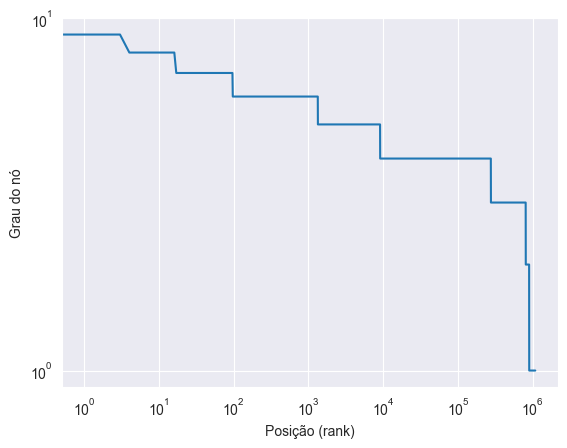

In [196]:
y = in_degree_list.sort_values(ascending=False)
x = range(len(y))
plt.plot(x, y)
plt.loglog()
plt.xlabel('Posição (rank)')
plt.ylabel('Grau do nó');

## Distâncias

Limite inferior para o diâmetro:

In [197]:
nx.algorithms.approximation.diameter(H)

789

In [198]:
distances = nx.shortest_path_length(H, '0')
distances = pd.Series(distances)
distances.describe()

count    1.087562e+06
mean     2.857163e+02
std      1.085169e+02
min      0.000000e+00
25%      2.070000e+02
50%      2.940000e+02
75%      3.610000e+02
max      5.410000e+02
dtype: float64

## Clusterização

Vamos criar uma cópia **não direcionada** da rede:

In [199]:
undirected = nx.to_undirected(H)
print(undirected)

Graph with 1087562 nodes and 3083028 edges


Clusterização muito pequena! Faz sentido?

In [200]:
nx.algorithms.approximation.average_clustering(undirected)

0.051

## Comparação com rede aleatória Erdös-Rényi

Rede muito grade -> **equações**

In [201]:
n = G.number_of_nodes()
p = nx.density(G)
n, p

(1088092, 2.6046825795723353e-06)

### Clusterização

Cada aresta tem probabilidade `p` de existir, a chance de haver uma aresta entre vizinhos é `p`

In [202]:
random_graph_clustering = p
random_graph_clustering

2.6046825795723353e-06

### Número de componentes

Componente gigante surge se grau médio é **maior do que 1**!

In [203]:
mean_degree = p * (n - 1)
mean_degree

2.834131672689442

### Diâmetro

Em uma rede aleatória, pode ser estimado pelo **número de nós** e **grau médio**:

In [204]:
random_graph_diameter = np.log(n) / np.log(mean_degree)
random_graph_diameter

13.343055795874397

### Distribuição dos graus

Graus seguem uma **Distribuição Binomial**:

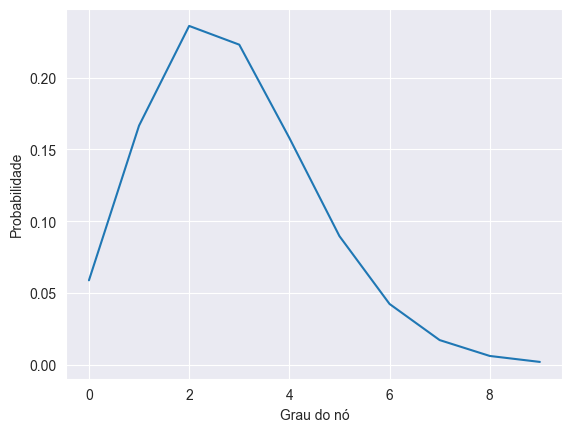

In [205]:
degree_dist = scipy.stats.binom(n - 1, p)
x = np.arange(10)
y = degree_dist.pmf(x)
plt.plot(x, y)
plt.xlabel('Grau do nó')
plt.ylabel('Probabilidade');

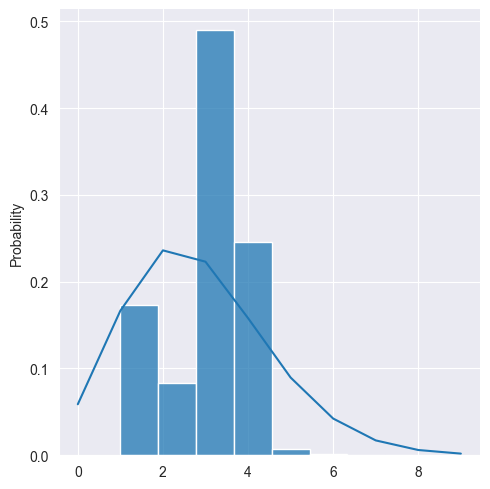

In [206]:
sns.displot(in_degree_list, stat='probability', bins=9)
plt.plot(x, y);

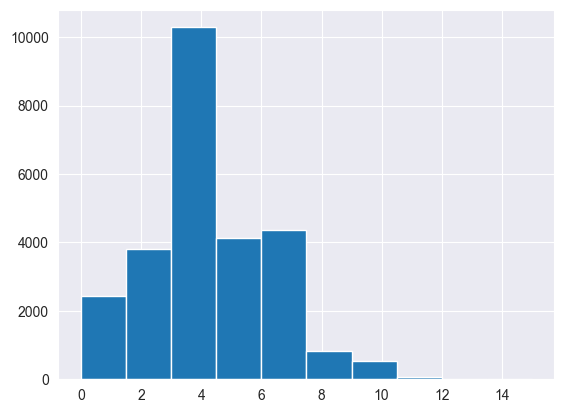

In [207]:
rng_degree_list = [degree for node, degree in random_graph.degree]
rng_degree_list = pd.Series(rng_degree_list)
rng_degree_list.hist();

# 4. Redes sociais

- Rede social do site [Slashdot](https://slashdot.org/)
- Aresta *friend or foe*

[Link para o dataset](https://snap.stanford.edu/data/soc-Slashdot0811.html)

Referência:
- J. Leskovec, K. Lang, A. Dasgupta, M. Mahoney. Community Structure in Large Networks: Natural Cluster Sizes and the Absence of Large Well-Defined Clusters. Internet Mathematics 6(1) 29--123, 2009.

In [208]:
url = 'https://snap.stanford.edu/data/soc-Slashdot0811.txt.gz'
file_path = download_file(url)
file_path

'soc-Slashdot0811.txt.gz'

In [209]:
G = nx.read_edgelist(file_path, create_using=nx.DiGraph)
print(G)

DiGraph with 77360 nodes and 905468 edges


## Densidade da rede

Muito parecida com a densidade da Internet!

In [210]:
nx.density(G)

0.0001513023935343928

## Conectividade

Fortemente conexo -> caminho de **ida e volta**

In [211]:
nx.is_strongly_connected(G)

False

Muitas **componentes conexas fortes**!

In [212]:
nx.number_strongly_connected_components(G)

6724

Separando a **maior componente conexa forte**:

In [213]:
components = nx.strongly_connected_components(G)
nodes = max(components, key=len)
H = G.subgraph(nodes)
print(H)

DiGraph with 70355 nodes and 888662 edges


Percentual de nós e arestas na **maior componente**:

In [214]:
H.number_of_nodes() / G.number_of_nodes()

0.9094493278179938

In [215]:
H.number_of_edges() / G.number_of_edges()

0.9814394324261045

Menor conectividade quando comparada às outras redes

## Distribuição dos graus

### Histograma

Grau de entrada:

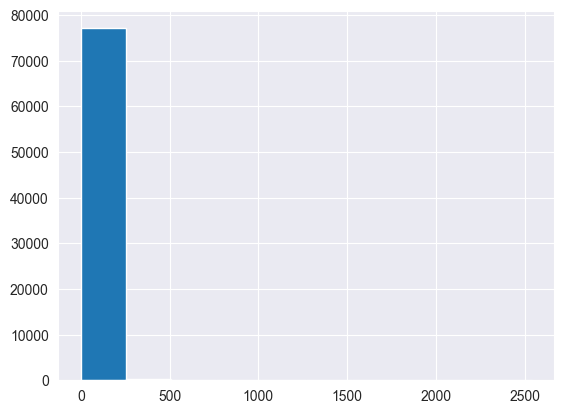

In [216]:
in_degree_list = [degree for node, degree in G.in_degree]
in_degree_list = pd.Series(in_degree_list)
in_degree_list.hist();

In [217]:
in_degree_list.describe()

count    77360.000000
mean        11.704602
std         37.205199
min          1.000000
25%          2.000000
50%          3.000000
75%          8.000000
max       2540.000000
dtype: float64

Grau de saída:

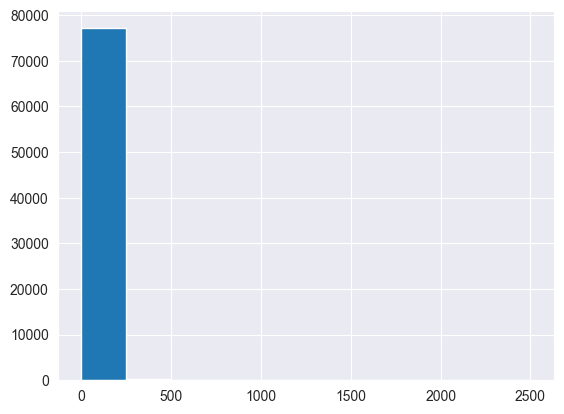

In [218]:
out_degree_list = [degree for node, degree in G.out_degree]
out_degree_list = pd.Series(out_degree_list)
out_degree_list.hist();

In [219]:
out_degree_list.describe()

count    77360.000000
mean        11.704602
std         36.844128
min          0.000000
25%          2.000000
50%          3.000000
75%          7.000000
max       2508.000000
dtype: float64

Graus de entrada e saída são parecidos

### Gráfico de *ranqueamento*

Será que segue Lei de Potência?

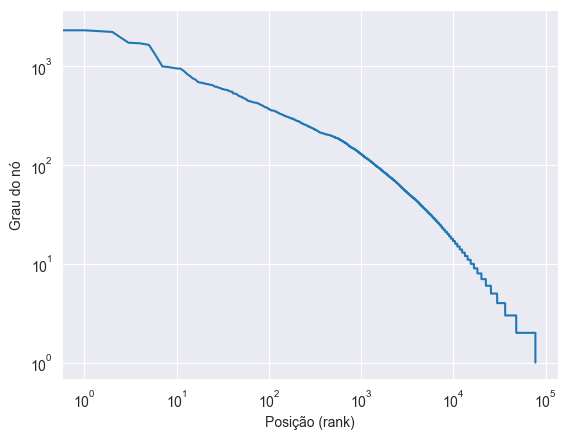

In [220]:
y = in_degree_list.sort_values(ascending=False)
x = range(len(y))
plt.plot(x, y)
plt.loglog()
plt.xlabel('Posição (rank)')
plt.ylabel('Grau do nó');

## Distâncias

Limite inferior para o diâmetro:

In [221]:
nx.algorithms.approximation.diameter(H)

12

In [222]:
distances = nx.shortest_path_length(H, '0')
distances = pd.Series(distances)
distances.describe()

count    70355.00000
mean         3.09435
std          0.66968
min          0.00000
25%          3.00000
50%          3.00000
75%          3.00000
max          7.00000
dtype: float64

## Clusterização

Vamos criar uma cópia **não direcionada** da rede:

In [223]:
undirected = nx.to_undirected(H)
print(undirected)

Graph with 70355 nodes and 923838 edges


Como em muitas redes sociais, clusterização é alta!

In [224]:
nx.algorithms.approximation.average_clustering(undirected)

0.598

## Comparação com rede aleatória Erdös-Rényi

Vamos aproveitar as equações!

In [225]:
n = G.number_of_nodes()
p = nx.density(G)
n, p

(77360, 0.0001513023935343928)

### Clusterização

Certamente não é uma rede aleatória!

In [226]:
random_graph_clustering = p
random_graph_clustering

0.0001513023935343928

### Número de componentes

Com grau médio > 1, tendência de formar uma **componente gigante**

In [227]:
mean_degree = p * (n - 1)
mean_degree

11.704601861427093

### Diâmetro

Na rede aleatória, esperamos um diâmetro menor:

In [228]:
random_graph_diameter = np.log(n) / np.log(mean_degree)
random_graph_diameter

4.575734593499139

### Distribuição dos graus

Graus seguem uma **Distribuição Binomial**:

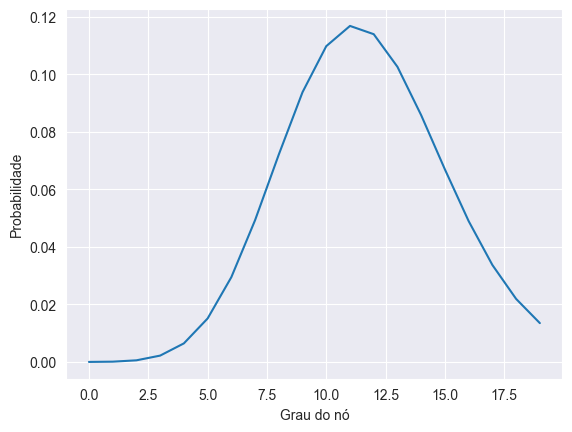

In [229]:
degree_dist = scipy.stats.binom(n - 1, p)
x = np.arange(20)
y = degree_dist.pmf(x)
plt.plot(x, y)
plt.xlabel('Grau do nó')
plt.ylabel('Probabilidade');

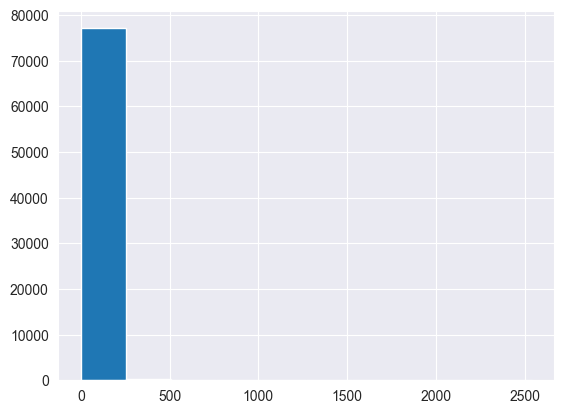

In [230]:
in_degree_list.hist();